In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [21]:
os.makedirs("../plots/sales_kpis", exist_ok=True)
df = pd.read_csv("../data/cleaned_superstore.csv")

In [22]:
df["Monetary"] = df[["MntWines", "MntFruits", "MntMeatProducts","MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)
df["Frequency"] = df[["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]].sum(axis=1)

In [23]:
df["R_Score"] = pd.qcut(df["Recency"], 5, labels=[5, 4, 3, 2, 1]).astype(int)
df["F_Score"] = pd.qcut(df["Frequency"].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
df["M_Score"] = pd.qcut(df["Monetary"].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

df["RFM_Score"] = df["R_Score"].astype(str) + df["F_Score"].astype(str) + df["M_Score"].astype(str)

In [24]:
def rfm_level(row):
    if row["R_Score"] >= 4 and row["F_Score"] >= 4 and row["M_Score"] >= 4:
        return "High Value"
    elif row["R_Score"] >= 3 and row["F_Score"] >= 3 and row["M_Score"] >= 3:
        return "Mid-High"
    elif row["R_Score"] >= 2 and row["F_Score"] >= 2 and row["M_Score"] >= 2:
        return "Mid-Low"
    else:
        return "Low Value"

df["RFM_Level"] = df.apply(rfm_level, axis=1)

In [25]:
df.to_csv("../data/cleaned_superstore_rfm.csv", index=False)

In [26]:
kpis = {"KPI": [], "Value": []}

In [27]:
# Total Sales
total_sales = df["Monetary"].sum()
kpis["KPI"].append("Total Sales")
kpis["Value"].append(round(total_sales, 2))

In [28]:
# Average Spend per Customer
avg_spend = df["Monetary"].mean()
kpis["KPI"].append("Average Spend per Customer")
kpis["Value"].append(round(avg_spend, 2))

In [29]:
# Average Order Value (AOV)
df_nonzero = df[df["Frequency"] > 0]
df_nonzero["AOV"] = df_nonzero["Monetary"] / df_nonzero["Frequency"]
aov = df_nonzero["AOV"].mean()

kpis["KPI"].append("Average Order Value (AOV)")
kpis["Value"].append(round(aov, 2))

/var/folders/3q/rggp33rx7374d1rnpz_q80nw0000gn/T/ipykernel_29025/4056400489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonzero["AOV"] = df_nonzero["Monetary"] / df_nonzero["Frequency"]


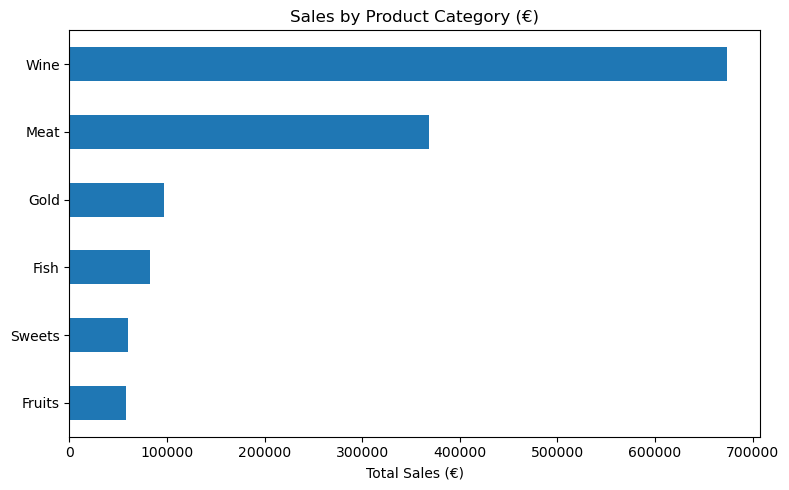

In [30]:
# Monetary by Product Category
category_columns = {
    "MntWines": "Wine",
    "MntFruits": "Fruits",
    "MntMeatProducts": "Meat",
    "MntFishProducts": "Fish",
    "MntSweetProducts": "Sweets",
    "MntGoldProds": "Gold"
}
category_sales = df[list(category_columns.keys())].sum().rename(index=category_columns)

kpis["KPI"].append("Monetary by Product Category")
kpis["Value"].append("; ".join([f"{k}: {v:.0f}€" for k, v in category_sales.items()]))

plt.figure(figsize=(8, 5))
category_sales.sort_values().plot(kind="barh")
plt.title("Sales by Product Category (€)")
plt.xlabel("Total Sales (€)")
plt.tight_layout()
plt.savefig("../plots/sales_kpis/sales_by_category.png")
plt.show()

In [31]:
top_category = category_sales.idxmax()
top_value = category_sales.max()

kpis["KPI"].append("Top Product Category by Spend")
kpis["Value"].append(f"{top_category}: {top_value:.0f}€")

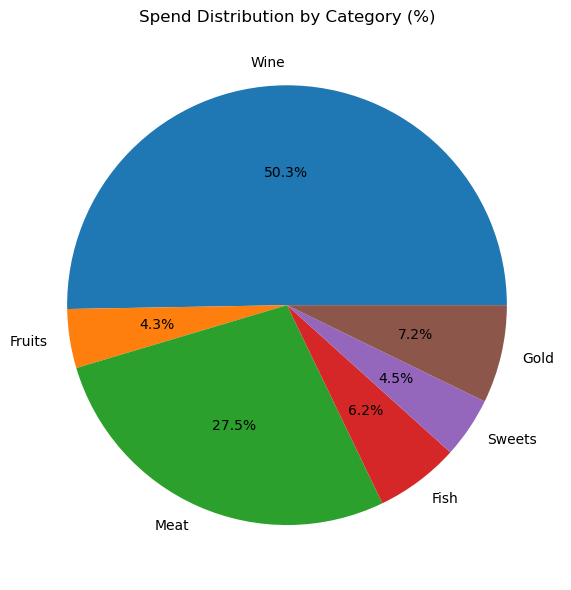

In [32]:
spend_dist_pct = (category_sales / total_sales) * 100

kpis["KPI"].append("Spend Distribution by Category (%)")
kpis["Value"].append("; ".join([f"{k}: {v:.2f}%" for k, v in spend_dist_pct.items()]))

plt.figure(figsize=(6, 6))
spend_dist_pct.plot(kind="pie", autopct="%1.1f%%")
plt.title("Spend Distribution by Category (%)")
plt.ylabel("")
plt.tight_layout()
plt.savefig("../plots/sales_kpis/spend_distribution_percent.png")
plt.show()

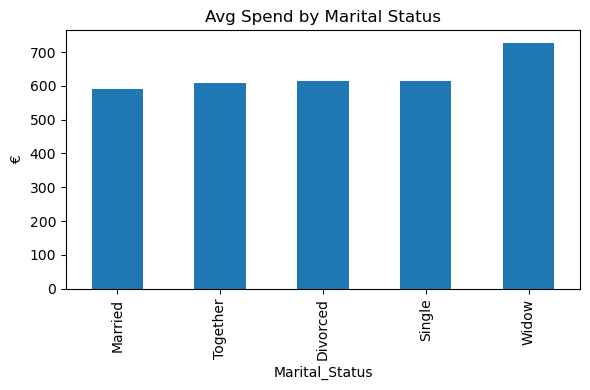

In [33]:
# Avg Spend by Marital Status
avg_by_marital = df.groupby("Marital_Status")["Monetary"].mean().sort_values()

kpis["KPI"].append("Avg Spend by Marital Status")
kpis["Value"].append("; ".join([f"{k}: {v:.2f}€" for k, v in avg_by_marital.items()]))

plt.figure(figsize=(6, 4))
avg_by_marital.plot(kind="bar", title="Avg Spend by Marital Status")
plt.ylabel("€")
plt.tight_layout()
plt.savefig("../plots/sales_kpis/avg_spend_by_marital_status.png")
plt.show()

/var/folders/3q/rggp33rx7374d1rnpz_q80nw0000gn/T/ipykernel_29025/745075917.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_income = df.groupby("Income_Bracket")["Monetary"].mean().sort_index()


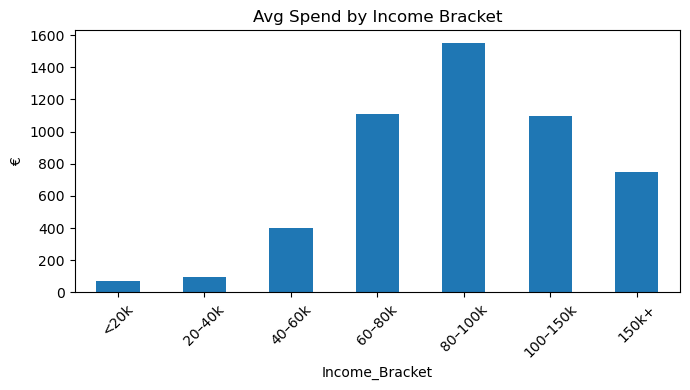

In [34]:
# Spend by Income Bracket
income_bins = [0, 20000, 40000, 60000, 80000, 100000, 150000, float("inf")]
bin_labels = ["<20k", "20–40k", "40–60k", "60–80k", "80–100k", "100–150k", "150k+"]

df["Income_Bracket"] = pd.cut(df["Income"], bins=income_bins, labels=bin_labels)
avg_by_income = df.groupby("Income_Bracket")["Monetary"].mean().sort_index()

kpis["KPI"].append("Avg Spend by Income Bracket")
kpis["Value"].append("; ".join([f"{k}: {v:.2f}€" for k, v in avg_by_income.items()]))

plt.figure(figsize=(7, 4))
avg_by_income.plot(kind="bar", title="Avg Spend by Income Bracket")
plt.ylabel("€")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../plots/sales_kpis/avg_spend_by_income_bracket.png")
plt.show()

In [35]:
df_rfm = pd.read_csv("../data/cleaned_superstore_rfm.csv")

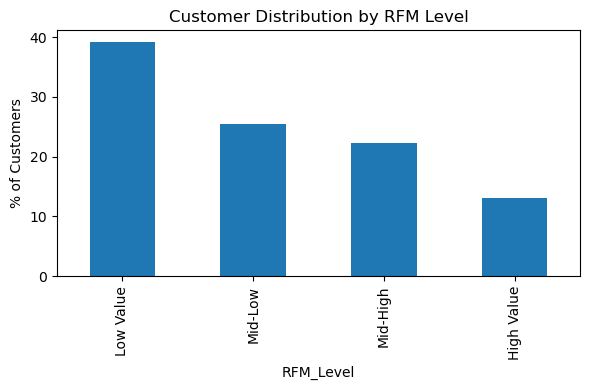

In [36]:
high_value_pct = (df["RFM_Level"] == "High Value").mean() * 100

kpis["KPI"].append("High Value Customers %")
kpis["Value"].append(f"{high_value_pct:.2f}%")

rfm_level_dist = df["RFM_Level"].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
rfm_level_dist.plot(kind="bar", title="Customer Distribution by RFM Level")
plt.ylabel("% of Customers")
plt.tight_layout()
plt.savefig("../plots/sales_kpis/rfm_level_distribution.png")
plt.show()

In [37]:
pd.DataFrame(kpis).to_csv("../exports/sales_kpis_summary.csv", index=False)